# Decision Tree for N-dimensional data and labels
The code below implements a decision tree calculated on all the data, for one label depending on several independent variables.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import cm
from math import log, e
import random
import sys

### Custom Libraries

In [2]:
import density_tree as dt
import density_tree.create_data
import density_tree.decision_tree_create
import density_tree.decision_tree_traverse
import density_tree.density_tree
import density_tree.plots

The methods implemented for producing a decision tree can be found in the python files under the package `density_tree`.


# Unsupervised entropy with unlabelled clusters
Below are some functions that compute an optimal split for unlabelled data, using the differential entropy of a d-variate Gaussian density. 

First, let's generate some unlabelled data:


In [3]:
def plotData(data, title, linesX = None, linesY = None, clusters = None, save=False, labels=True, minRange=1, maxRange=100, covariance = 2):
    """Plot the clustered data"""
    fig, ax = plt.subplots()

    if labels:
        color = iter(cm.rainbow(np.linspace(0, 1, len(clusters))))
        for i, c in enumerate(data):
            color_cluster = next(color)
            ax.plot(c[:, 0], c[:, 1], '.', color=color_cluster)

            x = c[:, 0]
            y = c[:, 1]
            n = [int(c) for c in c[:, 2]]

            for i, txt in enumerate(n):
                ax.annotate(txt, (x[i], y[i]))
    else:
        ax.plot(data[:, 0], data[:, 1], '.')

    ax.grid()
    plt.title(title)

    # draw split lines after partitioning
    if linesX is not None and linesY is not None:
        for y_line in range(len(linesY)):
            ax.axhline(y=linesY[y_line], c="red")
        for x_line in range(len(linesX)):
            ax.axvline(x=linesX[x_line], c="red")

    axes = plt.gca()
    axes.set_xlim([minRange - 4 * covariance, maxRange + 4 * covariance])
    axes.set_ylim([minRange - 4 * covariance, maxRange + 4 * covariance])

    if (save):
        plt.savefig('/Users/cyrilwendl/Documents/EPFL/Projet SIE/SIE-Project/random_data.pdf', bbox_inches='tight')

    plt.show()

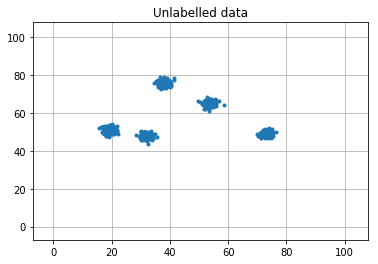

In [4]:
dimensions = 2
nclusters = 5
covariance =  2
npoints = 100
minRange = 10
maxRange = 100

dataset, clusters = dt.create_data.createData(nclusters, dimensions, covariance, npoints, 
                                              minRange=minRange, maxRange=maxRange)
dataset=dataset[:,:-1]
plotData(dataset,title="Unlabelled data",labels=False)

For tree descent, we have to decide how many clusters we want to produce (limit depth) or what should be the threshold of information gain for the algorithm to stop (information gain limit)

In [5]:
#%%writefile ./density_tree/decision_tree_create.py
"""Functions for entropy and splitting"""

import numpy as np
import pandas as pd

def entropy(labels, base=np.e):  # [1]
    """
    Calculate the entropy for a set of labels.
    :param labels: an array of labels
    :param base: base of entropy, by default e
    :return: entropy
    """
    value, counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    return -(norm_counts * np.log(norm_counts) / np.log(base)).sum()

def entropy_discrete(dataset, dim):
    """
    calculate the entropy values for all cuts on one attribute (left<cut, right>=cut).
    :param dataset: Input array with data and label in rows. The last column contains the labels.
    :param dim: The index of the column for which the entropy should be computed.
    :return: entropy values, corresponding split values
    """
    x_vals, entropy_vals = list(), list()
    uniquevals = (np.unique(dataset[:, dim]))
    left_labels_unique, right_labels_unique = list(), list()
    
    # loop all possible split values
    for split_x in uniquevals[1:]:
        # append value
        x_vals.append(split_x)

        # split on value
        left, right = split(dataset, dim, split_x)
        left = np.asarray(left)
        right = np.asarray(right)

        # labels
        left_labels = left[:, -1]  # last column = labels
        right_labels = right[:, -1]

        # unique labels
        left_labels_unique.append(np.unique(left_labels))
        right_labels_unique.append(np.unique(right_labels))

        # entropy for split
        left_entropy = entropy(left_labels, base=2)
        right_entropy = entropy(right_labels, base=2)

        # total entropy for attribute
        # TODO change to information gain
        entropy_attr_split = left_entropy * len(left) / len(dataset) + right_entropy * len(right) / len(dataset)
        entropy_vals.append(entropy_attr_split)

    return entropy_vals, x_vals, left_labels_unique, right_labels_unique


def data_to_clusters(dataset):
    """Helper function to get clusters from estimated labels"""
    clusters = []
    for val in np.unique(dataset[:, 2]):
        clusters.append(dataset[dataset[:, 2] == val])
    return clusters


def get_unique_labels(labels):
    ul_side, ul_side_c = [], []

    for i in labels:
        ul_side_c.append(len(np.unique(i)))  # count of unique values on right side
        if len(np.unique(i)) == 1:  # if there is only one label, print the label
            ul_side.append(i)
        else:  # if there are several labels, print the number of the labels
            ul_side.append(i)
            # ul_side.append('several')
    return ul_side, ul_side_c

def calc_entropy_attribute(dataset):
    '''find the lowest entropy for a given attribute'''
    dfs = []
    entropy_attr = []
    x_attr = []

    for attribute_ind in range(np.shape(dataset, )[1] - 1): # loop over all attributes

        # get the entropy for all cuts
        entropy_vals_attr, xs_vals_attr, left_l_unique, right_l_unique = entropy_discrete(dataset,attribute_ind)
        # get number of unique labels (= cluster) on both sides
        ul_l, ul_l_c = get_unique_labels(left_l_unique)
        ul_r, ul_r_c = get_unique_labels(right_l_unique)

        # append values for all splits to dataframe
        x_attr.append(xs_vals_attr)
        entropy_attr.append(np.asarray(entropy_vals_attr))
        
        df = pd.DataFrame({'cut value': x_attr[attribute_ind],
                           'entropy': list(entropy_attr[attribute_ind]),
                           'left clusters': ul_l_c,
                           'right clusters': ul_r_c,
                           'left labels': ul_l,
                           'right labels': ul_r},
                          columns=['cut value', 'entropy', 'left clusters',
                                   'right clusters', 'left labels', 'right labels'])
        df.reset_index(inplace=True)
        dfs.append(df)
        
    return dfs

"""
labelled: working ?
unlabelled: TODO adapt
"""
def next_split(left, right, results, root):
    """
    recursive method to split variables on dimension until all variables are contained in one subspace. G
    1. Get left (l) and right (r) based on split
    2. Check if labels unique
    3. Get entropies for all split values in ll rr
    4. Recurse -> 1.
    """
    for side in (left, right):  # loop both sides
        dt_node = Node() # decision tree node]
        dt_node.parent = root
        dt_node.labels = np.unique(np.asarray(side)[:, -1])  # get variables (in last column)
        
        if np.array_equal(left, side):
            dt_node.parent.left = dt_node
        elif np.array_equal(right, side):
            dt_node.parent.right = dt_node

        
        
        if len(dt_node.labels) > 1:  # if there are still more than one labels in a side
            side = np.asarray(side)
            dfs = calc_entropy_attribute(side)  # get entropies for all attributes within side
            min_df = get_best_attr(dfs)  # get best split value
            # dataframe
            results.append(min_df)
            
            dt_node.split_value = min_df["cut value"].values[0]
            dt_node.split_dimension = min_df["dimension"].values[0]
            left_new, right_new = split(side, 
                                        dt_node.split_dimension,
                                        dt_node.split_value) # get new left and right labels
            
            # save results for dataframe
            next_split(left_new, right_new, results, dt_node)  # split, recursion
            
def create_decision_tree(dataset, dimensions = 0, subsample = 0):
    """create decision tree be performing initial split,
    then recursively splitting until all labels are in unique bins
    """
    # TODO modify such as to take as entry number of variables to create tree on, number of data subsamples etc.
    
    root = Node() # initial node
    # initial split
    dfs = calc_entropy_attribute(dataset)
    min_df = get_best_attr(dfs)
    
    root.split_value = min_df["cut value"].values[0]
    root.split_dimension = min_df["dimension"].values[0]
    root.labels = np.unique(dataset[:,-1])
    
    left,right=split(dataset, 
                 min_df["dimension"].values[0], # dimension of min cut value
                 min_df["cut value"].values[0]) # min cut value
    results=[min_df]
    # recursively continue splitting
    next_split(left, right, results, root) # iterate
    return results, root

In [6]:
#%%writefile ./density_tree/density_tree.py
import numpy as np

"""unlabelled data"""
def entropy_gaussian(S, base=2):
    """
    Differential entropy of a d-variate Gaussian density
    :param S: dataset in R^(N*D)
    :param base: base of entropy
    :return: entropy
    """
    K = np.linalg.det(np.cov(S.T))
    d = np.shape(S)[1]
    
    entropy = np.multiply(np.power(2 * np.pi * np.exp(1), d), K)
    if entropy <= 0:
        return 0
    entropy = np.log(entropy) / (np.log(base) * 2)
    if np.isnan(entropy):
        entropy = 0
    return entropy

"""
labelled: ?
unlabelled: ?
"""
def get_ig_dim(dataset, dim, entropy_f = entropy_gaussian, base = 2):
    """for one dimension, get information gain"""
    ig_vals = []
    split_vals = []

    # loop over all possible cut values
    for split_val in np.linspace(dataset[2, dim],dataset[-2, dim],100):  # TODO remove 1:-2, find out why beginning and end cause crash
        # split values
        split_rand_l = dataset[dataset[:, dim] < split_val]
        split_rand_r = dataset[dataset[:, dim] >= split_val]
        
        # entropy
        entropy_l = entropy_f(split_rand_l, base=base)
        entropy_r = entropy_f(split_rand_r, base=base)
        entropy_tot = entropy_f(dataset, base=base)

        # information gain
        ig = entropy_tot - (entropy_l * len(split_rand_l) /
                            len(dataset) + entropy_r * len(split_rand_r) / len(dataset))
        # append split value and information gain
        split_vals.append(split_val)
        ig_vals.append(ig)

    return np.array(ig_vals), np.array(split_vals)

"""
unlabelled: working
labelled: ?
"""
def get_best_split(dataset):
    """for a given dimension, get best split based on information gain"""
    # get all information gains on all dimensions
    ig_dims_vals, split_dims_vals = [], []
    for dim in range(np.shape(dataset)[1]): # loop all dimensions
        ig_vals, split_vals = get_ig_dim(dataset, dim)
        ig_dims_vals.append(ig_vals)
        split_dims_vals.append(split_vals)

    # split dimension of maximum gain
    dim_max = np.argmax(np.max(ig_dims_vals,axis=1))
    
    # split value of maximum gain 
    # get all maximum values and take the middle if there are several possible maximum values
    middle_max_ind = np.where(np.equal(ig_dims_vals[dim_max],np.max(ig_dims_vals[dim_max]))) 
    middle_max_ind = int(np.floor(np.mean(middle_max_ind)))
    val_dim_max = split_dims_vals[dim_max][middle_max_ind]
    return dim_max, val_dim_max, ig_dims_vals, split_dims_vals

"""
unlabelled: ?
labelled: ?
"""
def get_best_attr(dfs):
    """get the attribute cutting which the information gain is highest"""
    min_e = np.infty

    for i in range(len(dfs)):  # loop all variables
        df = dfs[i]
        min_df_attr = df.loc[df['entropy'].argmin()]
        if min_df_attr['entropy'] < min_e:
            min_e = min_df_attr['entropy']
            min_df = pd.DataFrame(min_df_attr.drop("index")).transpose()
            min_df["dimension"] = i

    return min_df  # value of lowest entropy after possible cut, cut value, dimension

In [7]:
#%%writefile ./density_tree/decision_tree_traverse.py
# Binary tree node to save binary tree nodes

class Node:
    """
    constructor for new nodes
    # decision rule is the rule which splits labels in two groups labels_left and labels_right
    # left_rule and right_rule are pointers to the rules that have to be used
    # to further split labels_left and labels_right
    """

    def __init__(self):
        # data for node
        self.parent = None  # parent node
        self.labels = None  # the labels contained at this split level
        self.split_value = None  # the split value
        self.split_dimension = None  # the split dimension
        self.entropy = None  # entropy, for unlabelled nodes
        self.dataset = None
        self.dataset_left = None
        self.dataset_right = None

        # child nodes
        self.left = None  # node to the left, e.g., for value < split_value
        self.left_labels = None
        self.left_entropy = None
        self.right = None
        self.right_labels = None
        self.right_entropy = None

    def get_root(self):
        if self.parent != None:
            return self.parent.get_root()
        else:
            return self
        
    def has_children(self):
        """print data for node"""
        if (self.right != None) & (self.right != None):
            return True
        return False

    def depth(self):
        """get tree depth"""
        left_depth = self.left.depth() if self.left else 0
        right_depth = self.right.depth() if self.right else 0
        return max(left_depth, right_depth) + 1
    
    def highest_entropy(self, node, e, side):
        """get the node in tree which has the highest entropy,
        taking a root node as input.
        for every node, check the entropies left and right after splitting
        if the node is not split yet to one of the sides and the entropy on the unsplit side
        exceeds the  maximum entropy, return the node.
        """
        if self.left_entropy is not None and self.left is None:
            if self.left_entropy > e:
                node = self
                e = self.left_entropy
                side = 'left'
        
        if self.right_entropy is not None and self.right is None:
            if self.right_entropy > e:
                node = self
                e = self.right_entropy
                side = 'right'

        if self.left is not None:
            node_lower_l, e_lower_l, side_lower_l = self.left.highest_entropy(node, e, side)
        if self.right is not None:
            node_lower_r, e_lower_r, side_lower_r = self.right.highest_entropy(node, e, side)
        if self.left is not None:
            if e_lower_l > e:
                node, e, side = node_lower_l, e_lower_l, side_lower_l
        if self.right is not None:
            if e_lower_r > e:
                node, e, side = node_lower_r, e_lower_r, side_lower_r
                
        return node, e, side

    """traversal methods"""
    def traverse_inorder(self):
        if self.left is not None:
            self.left.traverse_inorder()
        self.__format__()
        if self.right is not None:
            self.right.traverse_inorder()

    def traverse_preorder(self):
        self.__format__()
        if self.left is not None:
            self.left.traverse_preorder()
        if self.right is not None:
            self.right.traverse_preorder()

    def traverse_postorder(self):
        if self.left is not None:
            self.left.traverse_preorder()
        if self.right is not None:
            self.right.traverse_preorder()
        self.__format__()
        raise NotImplementedError
        
    def __format__(self):
        # print("rule: " + self.decisionrule) # print a decision rule on one line as a string (e.g., `d(2) < 20`)
        print("labels: " + str(self.labels))
        if self.has_children():
            print("split dimension: " + str(self.split_dimension))
            print("split value: " + str(self.split_value))

In [8]:
def split(dataset, index, split_value, return_entropy = False):  # [2]
    """
    split a dataset (columns: variables, rows: data) in two according to some column (index) value.
    :param dataset: input dataset
    :param index: index of dimension to split values on
    :param split_value: value of the dimension where the dataset is split
    :return: left and right split datasets
    """
    left, right = [], []
    for row in dataset:
        if row[index] < split_value:
            left.append(row)
        else:
            right.append(row)

    left = np.asarray(left)
    right = np.asarray(right)
    
    if return_entropy:
        e_left = entropy_gaussian(left)
        e_right = entropy_gaussian(right)
        return left, right, e_left, e_right
    else:
        return left, right


def create_decision_tree_unlabelled(dataset, dimensions, clusters, subsample = 0, parentnode = None,
                                    side_label = None):
    """create decision tree be performing initial split,
    then recursively splitting until all labels are in unique bins
    init: flag for first iteration
    Principle:  create an initial split, save value, dimension, and entropies on node as well as on both split sides
    As long as total number of splits < nclusters - 1, perform another split on the side having the higher entropy
    Or, if there are parent nodes: perform a split on the side of the node that has the highest entropy on a side
    """
    # TODO modify such as to take as entry number of variables to create tree on, number of data subsamples etc.
    # split
    dim_max, val_dim_max, _, _ = get_best_split(dataset)
    left, right, e_left, e_right = split(dataset, dim_max, val_dim_max, return_entropy = True) # split along best dimension
    
    treenode = Node() # initial node
    # save tree node
    treenode.split_dimension = dim_max
    treenode.split_value = val_dim_max
    treenode.dataset = dataset
    treenode.dataset_left = left
    treenode.dataset_right = right
    treenode.entropy = entropy_gaussian(dataset)
    treenode.left_entropy = e_left
    treenode.right_entropy = e_right
    
    # link parent node to new node.
    if parentnode is not None:
        treenode.parent = parentnode
        if side_label == 'left':
            parentnode.left = treenode
        elif side_label == 'right':
            parentnode.right = treenode
    
    clusters_left = clusters - 1 
    if clusters_left > 1: 
        # recursively continue splitting
        # continue splitting always splitting on worst side (highest entropy)
        # find node where left or right entropy is highest and left or right node is not split yet
        node_e, e, side = treenode.get_root().highest_entropy(dataset, 0, 'None')
        if side == 'left':
            dataset = node_e.dataset_left
            side_label = 'left'
        elif side == 'right':
            dataset = node_e.dataset_right
            side_label = 'right'
            
        create_decision_tree_unlabelled(dataset, dimensions, clusters = clusters_left, parentnode = node_e, side_label=side_label) # iterate
    
    return treenode

In [9]:
root = create_decision_tree_unlabelled(dataset, dimensions=2, clusters = nclusters)

In [10]:
def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

cut_vals, cut_dims = get_values_preorder(root, [], [])
cut_vals = np.asarray(cut_vals)[np.not_equal(cut_vals,None)].astype(float)
cut_dims = np.asarray(cut_dims)[np.not_equal(cut_dims,None)].astype(int)

In [11]:
cut_vals, cut_dims

(array([ 57.69116197,  52.28075087,  25.28165745,  45.68113527]),
 array([1, 0, 0, 0]))

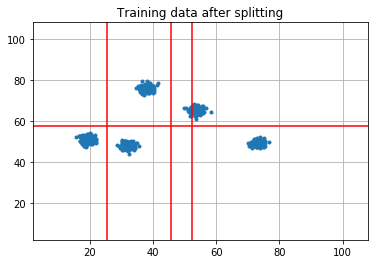

In [12]:
x_split = cut_vals[cut_dims == 0]
y_split = cut_vals[cut_dims == 1]
plotData(dataset, "Training data after splitting", x_split, y_split, labels=False,
                            minRange = minRange, maxRange = maxRange, covariance=covariance)

In [13]:
np.seterr(all='print')
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    dim_max, val_dim_max, ig_dims_vals, split_dims_vals  = get_best_split(dataset)

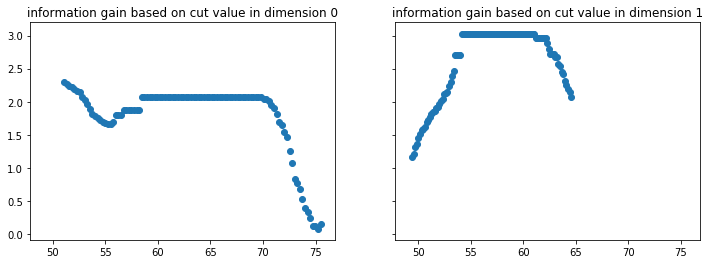

1 57.6911619731


In [14]:
def show_ig():
    f, axes = plt.subplots(1,2, sharex=True, sharey=True)
    f.set_size_inches((12,4))
    for dim in [0,1]:
        axes[dim].scatter(split_dims_vals[dim],ig_dims_vals[dim])
        axes[dim].set_title("information gain based on cut value in dimension "+str(dim))
    plt.show()
show_ig()
print(dim_max, val_dim_max)

# Labelled data

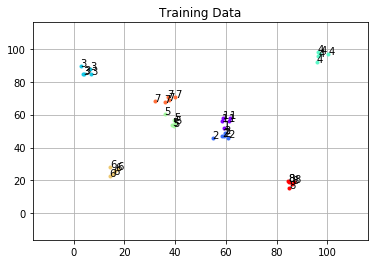

In [15]:
# cluster parameters
nclusters=8
dimensions=2
covariance=4
minRange=0
maxRange=100
npoints=5

    
dataset, clusters = dt.create_data.createData(nclusters, dimensions, covariance, npoints,)
plotData(clusters, title="Training Data", clusters=clusters,
                  minRange = minRange, maxRange = maxRange, covariance=covariance)

### Calculate the entropy over all possible split values in all dimensions (`calc_entropy attribute`)


Now we can iterate the same procedure over the both splitted sides until there is no split left.

In [16]:
results, root = create_decision_tree(dataset)
df_results=pd.concat(results)

In [17]:
root.depth()

4

,cut value,entropy,left clusters,right clusters,left labels,right labels,dimension
19,54.8219,2,4,4,"[3.0, 5.0, 6.0, 7.0]","[1.0, 2.0, 4.0, 8.0]",0
9,31.9262,1,2,2,"[3.0, 6.0]","[5.0, 7.0]",0
4,14.1536,-0,1,1,[3.0],[6.0],0
4,67.7521,-0,1,1,[5.0],[7.0],1
9,84.4717,1,2,2,"[1.0, 2.0]","[4.0, 8.0]",0
4,51.7009,-0,1,1,[2.0],[1.0],1
4,95.8247,-0,1,1,[8.0],[4.0],0


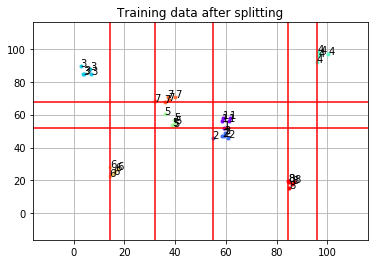

In [18]:
x_split=df_results[df_results["dimension"]==0]["cut value"].values
y_split=df_results[df_results["dimension"]==1]["cut value"].values

display(df_results)
plotData(clusters, "Training data after splitting", x_split, y_split,
                            minRange = minRange, maxRange = maxRange, clusters = clusters, covariance=covariance)

Next, we will output the decision forest to produce a $\LaTeX$ figure.

In [19]:
def print_rule(root):
    rule_string = str(root.split_dimension)+"$<$"+str(np.round(root.split_value,1))
    return rule_string
    #print(root.split_dimension,end="")

def printstuff(node,tree_string):
    tree_string+="["
    if len(node.labels) > 1:
        tree_string += print_rule(node)
        print_rule(node)
    else:
        tree_string+=str(int(node.labels))
    
    if node.has_children():
        tree_string =  printstuff(node.left,tree_string)
        tree_string =  printstuff(node.right,tree_string)
    tree_string+="]"
    
    return tree_string
tree_string=""
tree_string = printstuff(root,tree_string)

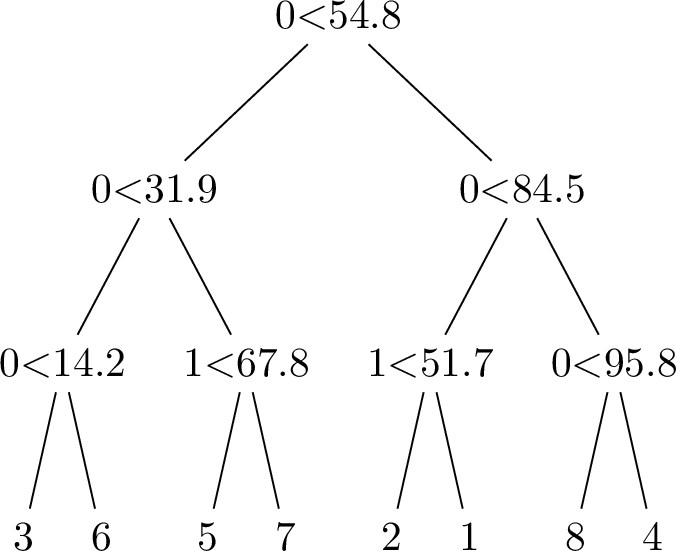

In [20]:
import os
import matplotlib.image as mpimg
from IPython.core.display import Image, display

os.system("cd figures; rm main.tex; more main_pt1.tex >> main.tex; echo '' >> main.tex;  echo '" + tree_string + "' >> main.tex;  more main_pt2.tex >> main.tex;")
os.system("cd figures; pdflatex main.tex; convert -density 300 -trim main.pdf -quality 100 main.png")
display(Image('./figures/main.png', retina=True))

## Test data set on regular grid
Next, we want to estimate the label of a new data point from the decision tree just built. We will always follow the path of strongest reduction of entropy.

In [21]:
def descend_decision_tree(data_test, node):
    """given some test data and decision tree, assign the correct label using a decision tree"""
    
    # check left or right side
    if len(node.labels) == 1:  # if there is only one label, return it
        return int(node.labels)
    
    if data_test[node.split_dimension] < node.split_value:  # split to the left    
        return descend_decision_tree(data_test, node.left)
    else:  # split to the right
        return descend_decision_tree(data_test, node.right)

In [22]:
dataset_test_eval=[]
spacing=3
for i in [[x,y] for x in range(minRange,maxRange,spacing) for y in range(minRange,maxRange,spacing)]:
    label=descend_decision_tree(i,root)
    dataset_test_eval.append(np.concatenate([i,[label]]))
    
dataset_test_eval=np.asarray(dataset_test_eval)

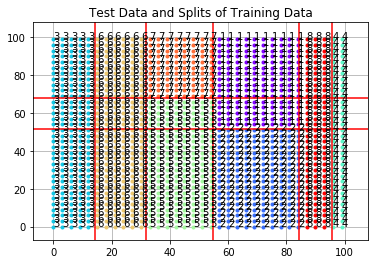

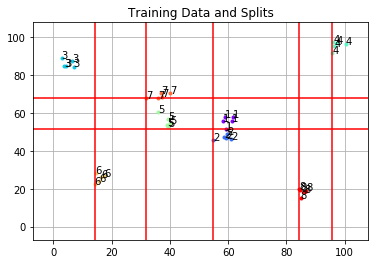

In [23]:
clusters_eval=data_to_clusters(dataset_test_eval)
plotData(clusters_eval, "Test Data and Splits of Training Data", x_split, y_split, clusters = clusters_eval)
plotData(clusters, "Training Data and Splits", x_split, y_split, clusters = clusters)